



### Introduction




The aim of this notebook is to find continuous gravitational-wave signals. The following code is a model (not so) sensitive enough to detect weak yet long-lasting signals emitted by rapidly-spinning neutron stars within noisy data.




 When scientists detected the first class of gravitational waves in 2015, they expected the discoveries to continue. There are four classes, yet at present only signals from merging black holes and neutron stars have been detected. Among those remaining are continuous gravitational-wave signals. These are weak yet long-lasting signals emitted by rapidly-spinning neutron stars. Imagine the mass of our Sun but condensed into a ball the size of a city and spinning over 1,000 times a second. The extreme compactness of these stars, composed of the densest material in the universe, could allow continuous waves to be emitted and then detected on Earth. There are potentially many continuous signals from neutron stars in our own galaxy and the current challenge for scientists is to make the first detection, and hopefully data science can help with this mission.

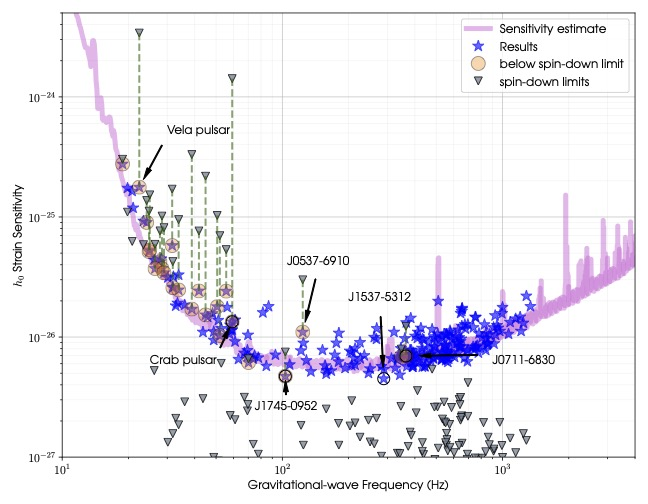







 This image, taken from a 2021 paper by the LIGO-Virgo-KAGRA collaboration, shows the maximum amplitude of a continuous wave any of these neutron stars could emit without being found by the search analyses. Circled stars show results constraining the physical properties of specific neutron stars. Traditional approaches to detecting these weak and hard-to-find continuous signals are based on matched-filtering variants. Scientists create a bank of possible signal waveform templates and ask how correlated each waveform is with the measured noisy data. High correlation is consistent with the presence of a signal similar to that waveform. Due to the long duration of these signals, banks could easily contain hundreds of quintillions of templates; yet, with so many possible waveforms, scientists don’t have the computational power to use the approach without making approximations that weaken the sensitivity to the signals.

### About the Data

Each data sample contains either real or simulated noise and possibly a simulated continuous gravitational-wave signal (CW). The task is to identify when a signal is present in the data (target=1).

Each sample is comprised of a set of Short-time Fourier Transforms (SFTs) and corresponding GPS time stamps for each interferometer. The SFTs are not always contiguous in time, since the interferometers are not continuously online.

The simulated signals are present throughout the entire duration of the set of SFTs in both detectors. The signals are characterised by the location and orientation of the hypothetical astrophysical source as well as two intrinsic parameters: frequency and spin-down. In total there are eight parameters which have all been randomised. These are not provided as part of the data. The typical amplitudes of the resulting signals are one or two orders of magnitude lower than the amplitude of the detector noise.



In [1]:
# Use timm pretrained image model
! pip3 install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 772.8 kB/s eta 0:00:00


In [2]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import h5py
import timm
import torch
import torch.utils as utils
import torch.nn as nn
import torch.nn.functional as F
import random
import gc,os,sys,shutil

from tqdm.auto import tqdm
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.metrics import roc_auc_score
from timm.scheduler import CosineLRScheduler

from transformers.file_utils import is_torch_tpu_available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
criterion = nn.BCEWithLogitsLoss()

# Train metadata
di = '/kaggle/input/g2net-detecting-continuous-gravitational-waves'
df = pd.read_csv(di + '/train_labels.csv')
df = df[df.target >= 0]  # Remove 3 unknowns (target = -1)

In [3]:
device

'cuda'

In [4]:
# params
PRETRAIN = True
SINGLE_MODEL = True
IMG_SIZE = None
MODEL_NAME = 'tf_efficientnet_b4_ns'

#MODEL_NAME = 'tf_efficientnet_b5_ns'

#MODEL_NAME = 'eca_nfnet_l3'
# MODEL_NAME = 'levit_192'
# IMG_SIZE = 224 # resize the images for a specific image models
N_FOLD = 5

# shapes to resize the images
SHAPE_1 = (180,23)
SHAPE_2 = (360,1)

In [5]:
#dataset
class ZipDataset(torch.utils.data.Dataset):
    """
    img, y = dataset[i]
      img (np.float32): 2 x 360 x 180
      y (np.float32): label 0 or 1
    """
    def __init__(self, pos_len=5000, neg_len=9900, path='../input/g2net-generated-data-1/',mod= 100, noise = 0.99):
        self.path = path
        self.mod = int(mod)
        self.noise = noise
        self.noise_type = 2
        
        self.pos_len = pos_len
        self.neg_len = neg_len
        self.len = pos_len + neg_len
        
        self.mixup = True
        self.mixup_prob = 0.1
        self.perm_pos = np.random.permutation(np.arange(self.pos_len))
        self.perm_neg = np.random.permutation(np.arange(self.neg_len))
    def __len__(self):
        return self.len
    def gen_noise(self, shape):
        ns = 0.15
        nr = 0.05

        noise_shape = (360*4140)
        noise_L_r = self.gen_noise(noise_shape)
        noise_H_r = noise_L_r*(1-ns)+self.gen_noise(noise_shape)*ns
        noise_L_i = noise_L_r*(1-nr)+self.gen_noise(noise_shape)*nr
        noise_H_i = noise_H_r*(1-nr)+self.gen_noise(noise_shape)*nr

        noise_r = np.stack([noise_L_r,noise_H_r]) *1e22
        noise_i = np.stack([noise_L_i,noise_H_i]) *1e22
        img_n = noise_r**2 + noise_i**2
        return img_n
    def get_negative(self,i):
        file_name = f'../input/g2net-generated-signals/archive/0_data_{self.mod*(1+(i)//self.mod)}/signals_{i%self.mod}.npy'
        img = np.load(file_name).astype(np.float64)
        y=0.0
        return img, y
    def get_positive(self, i):
        file_name = f'../input/g2net-generated-signals/archive/1_data_{self.mod*(1+(i)//self.mod)}/signals_{i%self.mod}.npy'
        img = np.load(file_name).astype(np.float64)
        
        noise_id = int(random.random()*self.neg_len)
        noise_r = random.random()*0.05+0.95
        img = (np.sqrt(img)*(1-noise_r)+np.sqrt(self.get_negative(noise_id)[0])*noise_r)**2
        y=1.0
        return img, y
    def get_noise(self):
        return self.noise
    def get_mixup(self, i, t):
        if t==1:
            mix_img = (self.get_positive(i)[0] + self.get_positive(self.perm_pos[i])[0])/2
            if random.random() < 1/self.pos_len:
                self.pos_perm = np.random.permutation(np.arange(self.pos_len))
        else:
            mix_img = (self.get_negative(i)[0] + self.get_negative(self.perm_neg[i])[0])/2
            if random.random() < 1/self.neg_len:
                self.neg_perm = np.random.permutation(np.arange(self.neg_len))
        return mix_img, t
    def __getitem__(self, i):
        if i<self.pos_len:
            if self.mixup and random.random() < self.mixup_prob:
                img, y = self.get_mixup(i,1)
            else:
                img, y = self.get_positive(i)
        else:
            i = i-self.pos_len
            if self.mixup and random.random() < self.mixup_prob:
                img, y = self.get_mixup(i,0)
            else:
                img, y = self.get_negative(i)
        img = ((img)/img.mean() ).astype(np.float32)
        return img, y
    
class H5Dataset(torch.utils.data.Dataset):
    """
    dataset = Dataset(data_type, df)

    img, y = dataset[i]
      img (np.float32): 2 x 360 x 128
      y (np.float32): label 0 or 1
    """
    def __init__(self, data_type, df):
        self.data_type = data_type
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        """
        i (int): get ith data
        """
        r = self.df.iloc[i]
        y = np.float32(r.target)
        file_id = r.id

        img = np.empty((2, SHAPE_2[0], SHAPE_1[0]), dtype=np.float32)

        filename = '%s/%s/%s.hdf5' % (di, self.data_type, file_id)
        with h5py.File(filename, 'r') as f:
            g = f[file_id]

            for ch, s in enumerate(['H1', 'L1']):
                a = g[s]['SFTs'][:, :SHAPE_1[0]*SHAPE_1[1]] * 1e22  # Fourier coefficient complex64

                p = a.real**2 + a.imag**2  # power
                p = np.mean(p.reshape(360, SHAPE_1[0],SHAPE_1[1]), axis=2)
                p = np.mean(p.reshape(SHAPE_2[0],SHAPE_2[1],SHAPE_1[0]), axis=1)

                img[ch] = p
        img = ((img)/img.mean()).astype(np.float32)
        return img, y

In [6]:
dataset = H5Dataset('train', df)
dataset = ZipDataset()

In [7]:
#model
class Model(nn.Module):
    def __init__(self, name, *, pretrained=False):
        """
        name (str): timm model name, e.g. tf_efficientnet_b2_ns
        """
        super().__init__()

        # Use timm
        model = timm.create_model(name, pretrained=pretrained, in_chans=2,num_classes = 2).to(device)
        self.use_head=True
        
        if name[:9] == 'eca_nfnet':
            clsf = 'head'
            n_features = model._modules['head'].fc.in_features
            model._modules[clsf].fc = nn.Identity()
        elif name[:15] == 'tf_efficientnet':
            clsf = model.default_cfg['classifier']
            n_features = model._modules[clsf].in_features
            model._modules[clsf] = nn.Identity()
        else:
            self.use_head=False
            #placeholder
            n_features=1
        self.fc = nn.Linear(n_features, 1)
        self.model = model

    def forward(self, x):
        if IMG_SIZE:
            x = F.interpolate(x,IMG_SIZE)
        
        x = self.model(x)
        if self.use_head:
            x = self.fc(x)
        else:
            x = x[:,0]
        return x

In [8]:
#evaluation (to predict and compute loss & score)
def evaluate(model, loader_val, *, compute_score=True, pbar=None):
    """
    Predict and compute loss and score
    """
    tb = time.time()
    was_training = model.training
    model.eval()

    loss_sum = 0.0
    n_sum = 0
    y_all = []
    y_pred_all = []

    if pbar is not None:
        pbar = tqdm(desc='Predict', nrows=78, total=pbar)

    for img, y in loader_val:
        n = y.size(0)

        with torch.no_grad():
            y_pred = model(img.to(device))
        loss = criterion(y_pred.view(-1).to(device), y.to(device))

        n_sum += n
        loss_sum += n * loss.item()

        y_all.append(y.cpu().detach().numpy())
        #y_all.append(y)
        y_pred_all.append(y_pred.sigmoid().squeeze().cpu().detach().numpy())
        
        #y_pred_all.append(y_pred.sigmoid().squeeze())

        if pbar is not None:
            pbar.update(len(img))
        
        del loss, y_pred, img, y
        gc.collect()

    loss_val = loss_sum / n_sum

    y = np.concatenate(y_all)
    y_pred = np.concatenate(y_pred_all)

    score = roc_auc_score(y, y_pred) if compute_score else None

    ret = {'loss': loss_val,
           'score': score,
           'y': y,
           'y_pred': y_pred,
           'time': time.time() - tb}
    
    model.train(was_training)  # back to train from eval if necessary
    gc.collect()
    return ret

In [9]:
#training with nfolds
if  SINGLE_MODEL:
    kfold = StratifiedKFold(n_splits=N_FOLD, random_state=42, shuffle=True)
    
    epochs = 6
    batch_size = 32
    weight_decay = 1e-6
    max_grad_norm = 1000

    lr_max = 4e-4
    epochs_warmup = 1.0

    losses = []
    scores = []

    for ifold, (idx_train, idx_test) in enumerate(kfold.split(df,df.target)):
        print('Fold %d/%d' % (ifold, N_FOLD))
        torch.manual_seed(42 + ifold + 1)

        # Train - val split
        dataset_train = H5Dataset('train', df.iloc[idx_train])
        dataset_val = H5Dataset('train', df.iloc[idx_test])

        loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size,
                         num_workers=0, pin_memory=False, shuffle=True, drop_last=True)
        loader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size,
                         num_workers=0, pin_memory=False)

        # Model and optimizer
    #     model = Model(MODEL_NAME, pretrained=True)
        model = Model(MODEL_NAME, pretrained=True)
        if not PRETRAIN:
            model.load_state_dict(torch.load('model_pretrain.pytorch'))
        model.to(device)
        model.train()

        optimizer = torch.optim.AdamW(model.parameters(), lr=lr_max, weight_decay=weight_decay)

        # Learning-rate schedule
        nbatch = len(loader_train)
        warmup = epochs_warmup * nbatch  # number of warmup steps
        nsteps = epochs * nbatch        # number of total steps

        scheduler = CosineLRScheduler(optimizer,
                      warmup_t=warmup, warmup_lr_init=0.0, warmup_prefix=True, # 1 epoch of warmup
                      t_initial=(nsteps - warmup), lr_min=1e-6)                # 3 epochs of cosine

        time_val = 0.0
        lrs = []

        tb = time.time()
        print('Epoch   loss          score   lr')

        best_val_loss = 1e10
        best_val_score=0
        for iepoch in range(epochs):
            loss_sum = 0.0
            n_sum = 0

            # Train
            for ibatch, (img, y) in tqdm(enumerate(loader_train)):
                n = y.size(0)
                img = img.to(device)
                y = y.to(device)

                optimizer.zero_grad()

                y_pred = model(img)
                loss = criterion(y_pred.view(-1), y)

                loss_train = loss.item()
                loss_sum += n * loss_train
                n_sum += n

                loss.backward()

                grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(),
                                                           max_grad_norm)

                optimizer.step()

                scheduler.step(iepoch * nbatch + ibatch + 1)
                lrs.append(optimizer.param_groups[0]['lr'])            

            # Evaluate
            val = evaluate(model, loader_val)
            time_val += val['time']
            loss_train = loss_sum / n_sum
            lr_now = optimizer.param_groups[0]['lr']
            dt = (time.time() - tb) / 60
            print('Epoch %d %.4f %.4f %.4f  %.2e  %.2f min' %
                  (iepoch + 1, loss_train, val['loss'], val['score'], lr_now, dt))
            if val['loss']<best_val_loss:
                best_val_loss = val['loss']
            if val['score']>best_val_score:
                best_val_score = val['score']
                ofilename = 'model%d.pytorch' % ifold
                torch.save(model.state_dict(), ofilename)
                print(ofilename, 'written')
        dt = time.time() - tb
        print('Training done %.2f min total, %.2f min val' % (dt / 60, time_val / 60))
        losses.append(best_val_loss)
        scores.append(best_val_score)
    print('AVG LOSS:', np.mean(np.array(best_val_loss)))
    print('AVG SCORE:', np.mean(np.array(best_val_score)))

Fold 0/5


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b4_ns-d6313a46.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b4_ns-d6313a46.pth


Epoch   loss          score   lr


0it [00:00, ?it/s]

Epoch 1 0.6584 0.6393 0.5169  4.00e-04  2.82 min
model0.pytorch written


0it [00:00, ?it/s]

Epoch 2 0.2824 0.6815 0.4494  3.62e-04  5.56 min


0it [00:00, ?it/s]

Epoch 3 0.0584 1.8692 0.5802  2.62e-04  8.37 min
model0.pytorch written


0it [00:00, ?it/s]

Epoch 4 0.0363 1.0935 0.6922  1.39e-04  11.26 min
model0.pytorch written


0it [00:00, ?it/s]

Epoch 5 0.0172 1.1073 0.6897  3.91e-05  14.15 min


0it [00:00, ?it/s]

Epoch 6 0.0091 1.0238 0.6775  1.00e-06  16.87 min
Training done 16.87 min total, 3.26 min val
Fold 1/5
Epoch   loss          score   lr


0it [00:00, ?it/s]

Epoch 1 0.6675 0.6983 0.3628  4.00e-04  2.74 min
model1.pytorch written


0it [00:00, ?it/s]

Epoch 2 0.3061 0.9498 0.5041  3.62e-04  5.46 min
model1.pytorch written


0it [00:00, ?it/s]

Epoch 3 0.0428 2.0255 0.5350  2.62e-04  8.14 min
model1.pytorch written


0it [00:00, ?it/s]

Epoch 4 0.0199 1.1259 0.6722  1.39e-04  10.86 min
model1.pytorch written


0it [00:00, ?it/s]

Epoch 5 0.0161 1.3281 0.6350  3.91e-05  13.58 min


0it [00:00, ?it/s]

Epoch 6 0.0077 1.3500 0.6375  1.00e-06  16.25 min
Training done 16.25 min total, 3.24 min val
Fold 2/5
Epoch   loss          score   lr


0it [00:00, ?it/s]

Epoch 1 0.6575 0.6366 0.6256  4.00e-04  2.79 min
model2.pytorch written


0it [00:00, ?it/s]

Epoch 2 0.3204 0.7405 0.5272  3.62e-04  5.58 min


0it [00:00, ?it/s]

Epoch 3 0.0661 2.9532 0.5995  2.62e-04  8.28 min


0it [00:00, ?it/s]

Epoch 4 0.0431 1.3731 0.6438  1.39e-04  10.97 min
model2.pytorch written


0it [00:00, ?it/s]

Epoch 5 0.0338 1.2803 0.5844  3.91e-05  13.68 min


0it [00:00, ?it/s]

Epoch 6 0.0134 1.1604 0.5903  1.00e-06  16.41 min
Training done 16.41 min total, 3.21 min val
Fold 3/5
Epoch   loss          score   lr


0it [00:00, ?it/s]

Epoch 1 0.6726 0.6606 0.3875  4.00e-04  2.83 min
model3.pytorch written


0it [00:00, ?it/s]

Epoch 2 0.3260 0.6824 0.4009  3.62e-04  5.66 min
model3.pytorch written


0it [00:00, ?it/s]

Epoch 3 0.0551 1.4294 0.5384  2.62e-04  8.42 min
model3.pytorch written


0it [00:00, ?it/s]

Epoch 4 0.0634 0.7960 0.6956  1.39e-04  11.25 min
model3.pytorch written


0it [00:00, ?it/s]

Epoch 5 0.0612 1.0071 0.6937  3.91e-05  14.13 min


0it [00:00, ?it/s]

Epoch 6 0.0122 0.9420 0.6994  1.00e-06  17.15 min
model3.pytorch written
Training done 17.15 min total, 3.31 min val
Fold 4/5
Epoch   loss          score   lr


0it [00:00, ?it/s]

Epoch 1 0.6549 0.6864 0.4594  4.00e-04  2.92 min
model4.pytorch written


0it [00:00, ?it/s]

Epoch 2 0.3242 0.9795 0.3872  3.62e-04  5.81 min


0it [00:00, ?it/s]

Epoch 3 0.0562 1.6294 0.5844  2.62e-04  8.65 min
model4.pytorch written


0it [00:00, ?it/s]

Epoch 4 0.0258 1.0865 0.7253  1.39e-04  11.52 min
model4.pytorch written


0it [00:00, ?it/s]

Epoch 5 0.0097 0.9922 0.7659  3.91e-05  14.38 min
model4.pytorch written


0it [00:00, ?it/s]

Epoch 6 0.0059 0.9653 0.7613  1.00e-06  17.14 min
Training done 17.14 min total, 3.37 min val
AVG LOSS: 0.6863955537478129
AVG SCORE: 0.7659374999999999


In [10]:
if SINGLE_MODEL:
    epochs = 1
    batch_size = 32
    weight_decay = 1e-6
    max_grad_norm = 1000
    lr_max = 4e-4
    epochs_warmup = 1.0

    dataset_train = H5Dataset('train',df)

    loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size,
                     num_workers=0, pin_memory=False, shuffle=True)

    model = Model(MODEL_NAME, pretrained=True)
    if not PRETRAIN:
        model.load_state_dict(torch.load('model_pretrain.pytorch'))
    model.to(device)
    model.train()

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr_max, weight_decay=weight_decay)

    # Learning-rate schedule
    nbatch = len(loader_train)
    warmup = epochs_warmup * nbatch  # number of warmup steps
    nsteps = epochs * nbatch        # number of total steps

    time_val = 0.0

    tb = time.time()
    print('Epoch   loss          score   lr')

    for iepoch in range(epochs):

        # Train
        for ibatch, (img, y) in tqdm(enumerate(loader_train)):
            n = y.size(0)
            img = img.to(device)
            y = y.to(device)

            optimizer.zero_grad()

            y_pred = model(img)
            loss = criterion(y_pred.view(-1), y)

            loss_train = loss.item()
            loss_sum += n * loss_train
            n_sum += n

            loss.backward()

            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(),
                                                       max_grad_norm)
            optimizer.step()
    dt = time.time() - tb
    print('Training done %.2f min total, %.2f min val' % (dt / 60, time_val / 60))

Epoch   loss          score   lr


0it [00:00, ?it/s]

Training done 2.73 min total, 0.00 min val


In [11]:
# Load model (if necessary)
submit = pd.read_csv(di + '/sample_submission.csv')
model = Model(MODEL_NAME, pretrained=False)
model.to(device)

if not PRETRAIN:
    model.load_state_dict(torch.load('model_pretrain.pytorch'))
    model.eval()
    dataset_test = H5Dataset('test', submit)
    loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=64,
                                              num_workers=0, pin_memory=False)
    test = evaluate(model, loader_test, compute_score=False, pbar=len(submit))
    submit['target'] += test['y_pred']
else:
    for i in range(N_FOLD):
        filename = f'model{i}.pytorch'
        model.load_state_dict(torch.load(filename, map_location=device))
        model.eval()

        # Predict
        dataset_test = H5Dataset('test', submit)
        loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=64,
                                                  num_workers=2, pin_memory=True)

        test = evaluate(model, loader_test, compute_score=False, pbar=len(submit))
        submit['target'] += test['y_pred']/ N_FOLD

# Write prediction
submit['target'] = test['y_pred']
submit.to_csv('submission_1.csv', index=False)

Predict:   0%|          | 0/7975 [00:00<?, ?it/s]

Predict:   0%|          | 0/7975 [00:00<?, ?it/s]

Predict:   0%|          | 0/7975 [00:00<?, ?it/s]

Predict:   0%|          | 0/7975 [00:00<?, ?it/s]

Predict:   0%|          | 0/7975 [00:00<?, ?it/s]

In [12]:
print('target range [%.2f, %.2f]' % (submit['target'].min(), submit['target'].max()))

target range [0.00, 1.00]
